In [159]:
# Auto Preprocessing (AutoPrep)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy import stats

sns.set(style="whitegrid")


In [160]:
# Load your dataset
df = pd.read_csv("Supermart Grocery Sales - Retail Analytics Dataset.csv")

# Display first few rows
df.head()


,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu


In [161]:
print("🔹 Dataset Shape:", df.shape)
print("\n🔹 Missing Values:\n", df.isnull().sum())
print("\n🔹 Data Types:\n", df.dtypes)

# Convert 'Sales' column to numeric if needed
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce')
df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')

# Convert 'Order Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')


🔹 Dataset Shape: (9994, 11)

🔹 Missing Values:
 Order ID         0
Customer Name    0
Category         0
Sub Category     0
City             0
Order Date       0
Region           0
Sales            0
Discount         0
Profit           0
State            0
dtype: int64

🔹 Data Types:
 Order ID          object
Customer Name     object
Category          object
Sub Category      object
City              object
Order Date        object
Region            object
Sales              int64
Discount         float64
Profit           float64
State             object
dtype: object


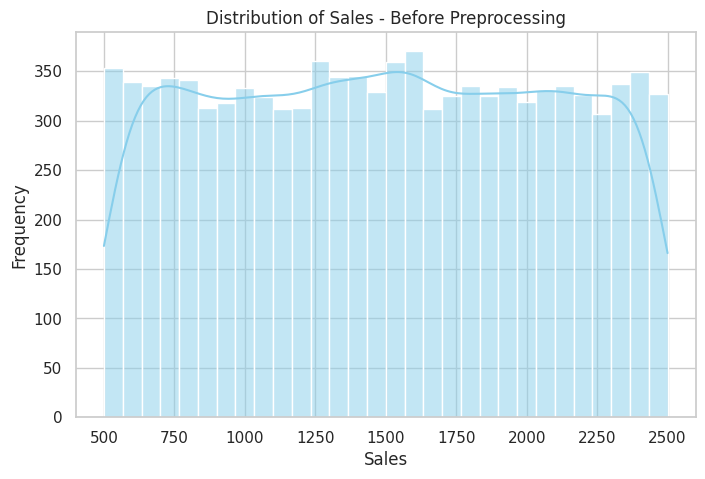

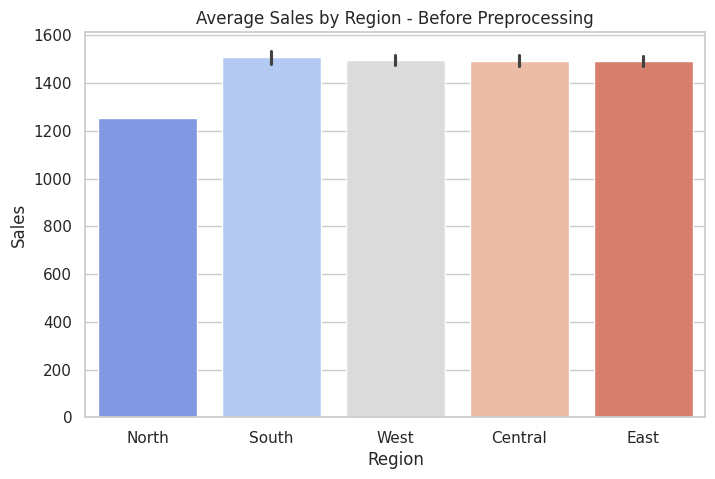

In [162]:
# Distribution of Sales (Before)
plt.figure(figsize=(8,5))
sns.histplot(df['Sales'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sales - Before Preprocessing')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Average Sales by Region (Before)
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Region', y='Sales', estimator=np.mean, palette='coolwarm')
plt.title('Average Sales by Region - Before Preprocessing')
plt.show()


In [163]:
# Detect and remove outliers using IQR
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Keep only valid range
df = df[(df['Sales'] >= Q1 - 1.5*IQR) & (df['Sales'] <= Q3 + 1.5*IQR)]
print("✅ After IQR Cleaning:", df.shape)


✅ After IQR Cleaning: (9994, 11)


In [164]:
# Handle missing numeric values with linear interpolation
df = df.interpolate(method='linear')

# Fill remaining missing categorical values with mode
for col in df.select_dtypes(exclude='number').columns:
    df[col] = df[col].fillna(df[col].mode()[0])


In [165]:
# Detect abnormal sales using Z-score
z_scores = np.abs(stats.zscore(df['Sales']))
df = df[(z_scores < 3)]
print("✅ After Z-score Outlier Removal:", df.shape)


✅ After Z-score Outlier Removal: (9994, 11)


In [166]:
label_enc = LabelEncoder()
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    df[col] = label_enc.fit_transform(df[col])

print("✅ Label Encoding Done for:", list(cat_cols))


✅ Label Encoding Done for: ['Order ID', 'Customer Name', 'Category', 'Sub Category', 'City', 'Region', 'State']


In [167]:
scaler = MinMaxScaler()
num_cols = ['Sales', 'Discount', 'Profit']
df[num_cols] = scaler.fit_transform(df[num_cols])

print("✅ Min–Max Normalization Done on:", num_cols)


✅ Min–Max Normalization Done on: ['Sales', 'Discount', 'Profit']


In [168]:
# Sort dataset by Order Date
df = df.sort_values(by='Order Date')

# 80% training, 20% testing (chronological)
split_point = int(len(df) * 0.8)
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:]

print("✅ Train Shape:", train_df.shape)
print("✅ Test Shape:", test_df.shape)


✅ Train Shape: (7995, 11)
✅ Test Shape: (1999, 11)


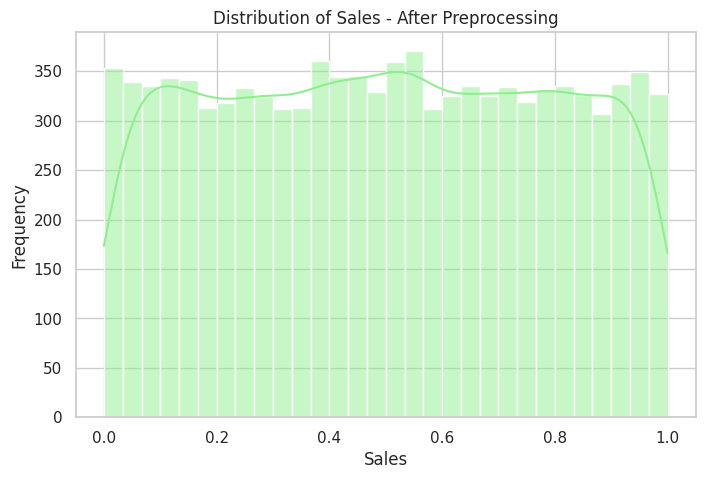

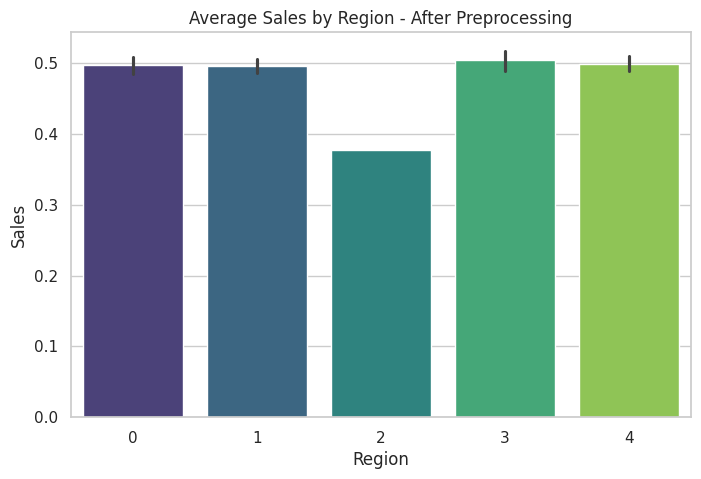

In [169]:
# Distribution of Sales (After)
plt.figure(figsize=(8,5))
sns.histplot(df['Sales'], bins=30, kde=True, color='lightgreen')
plt.title('Distribution of Sales - After Preprocessing')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Average Sales by Region (After)
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Region', y='Sales', estimator=np.mean, palette='viridis')
plt.title('Average Sales by Region - After Preprocessing')
plt.show()


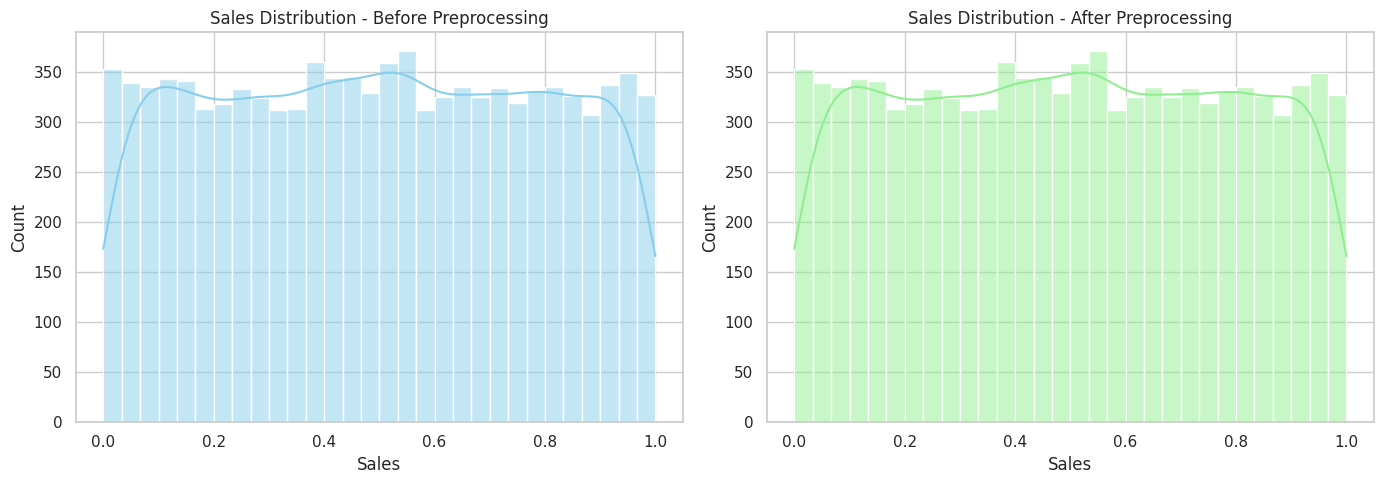

In [170]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Left: Before (Distribution)
sns.histplot(df['Sales'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Sales Distribution - Before Preprocessing')

# Right: After (Distribution)
sns.histplot(df['Sales'], bins=30, kde=True, color='lightgreen', ax=axes[1])
axes[1].set_title('Sales Distribution - After Preprocessing')

plt.tight_layout()
plt.show()


In [171]:
df.to_csv("Supermart_Cleaned.csv", index=False)
print("✅ Cleaned dataset saved as Supermart_Cleaned.csv")


✅ Cleaned dataset saved as Supermart_Cleaned.csv


## Granger-Based Forecasting
We leverage the cleaned dataset to build a Granger-causality driven Vector AutoRegression (VAR) model that forecasts future sales using past sales, discount, and profit signals.

In [172]:
%pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [173]:
import sys
import warnings
from pathlib import Path

# Ensure user site-packages (where statsmodels is installed) is on sys.path
user_site = Path.home() / ".local" / "lib" / f"python{sys.version_info.major}.{sys.version_info.minor}" / "site-packages"
if user_site.exists() and str(user_site) not in sys.path:
    sys.path.append(str(user_site))

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [174]:
# Load cleaned data and construct a daily multivariate time series
ts_df = pd.read_csv("Supermart_Cleaned.csv", parse_dates=["Order Date"])
ts_df = ts_df.sort_values("Order Date")
time_series = ts_df.set_index("Order Date")[["Sales", "Discount", "Profit"]]
time_series = time_series.resample("D").mean().interpolate()

time_series.head()

,Sales,Discount,Profit
Order Date,,,
2015-01-03,0.182000,0.640000,0.323912
2015-01-04,0.331667,0.586667,0.196970
2015-01-05,0.189000,1.000000,0.113179
2015-01-06,0.527364,0.589091,0.264466
2015-01-07,0.554000,0.040000,0.184676


In [175]:
# Granger causality test to verify that discount and profit history help forecast sales
max_lag = 6
granger_summary = {}

for driver in ["Discount", "Profit"]:
    tests = grangercausalitytests(time_series[["Sales", driver]], maxlag=max_lag, verbose=False)
    granger_summary[driver] = [round(tests[lag][0]["ssr_ftest"][1], 4) for lag in range(1, max_lag + 1)]

granger_results = pd.DataFrame(granger_summary, index=[f"Lag {lag}" for lag in range(1, max_lag + 1)])
granger_results

,Discount,Profit
Lag 1,0.0408,0.8791
Lag 2,0.1445,0.4877
Lag 3,0.2456,0.2822
Lag 4,0.3857,0.3189
Lag 5,0.4206,0.1132
Lag 6,0.4522,0.0882


In [176]:
# Train a VAR model using the Granger-validated drivers
split_idx = int(len(time_series) * 0.8)
train_var = time_series.iloc[:split_idx]
test_var = time_series.iloc[split_idx:]

order_selection = VAR(train_var).select_order(12)
selected_lag = order_selection.selected_orders['aic']
var_model = VAR(train_var).fit(selected_lag)

selected_lag

5

In [177]:
# Forecast on the hold-out window and evaluate accuracy for sales
lag_order = var_model.k_ar
forecast_input = train_var.values[-lag_order:]
forecast_values = var_model.forecast(y=forecast_input, steps=len(test_var))
forecast_df = pd.DataFrame(forecast_values, index=test_var.index, columns=test_var.columns)

actual_sales = test_var['Sales']
predicted_sales = forecast_df['Sales']
mse = mean_squared_error(actual_sales, predicted_sales)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_sales, predicted_sales)
mape = (np.abs((actual_sales - predicted_sales) / np.clip(actual_sales, 1e-4, None))).mean() * 100
r2 = r2_score(actual_sales, predicted_sales)

pd.Series({"RMSE": rmse, "MAE": mae, "MAPE (%)": mape, "R2": r2})

RMSE         0.140954
MAE          0.101880
MAPE (%)    43.774678
R2          -0.007032
dtype: float64

,Metric,Value
0,RMSE,0.140954
1,MAE,0.101880
2,MAPE (%),43.774678
3,R2,-0.007032


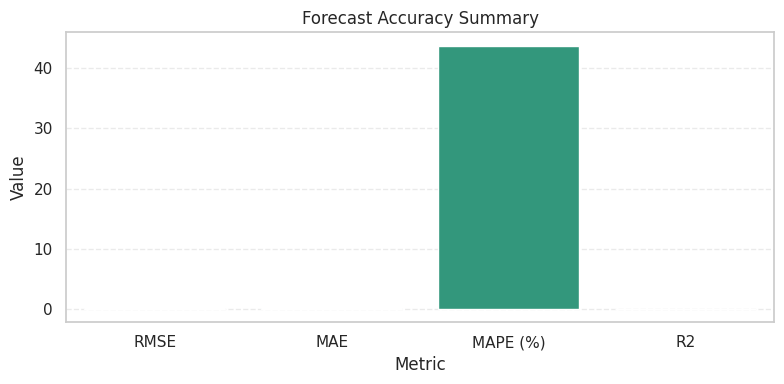

In [178]:
# Visualize error metrics for quick comparison
metrics_df = pd.DataFrame({"Metric": ["RMSE", "MAE", "MAPE (%)", "R2"],
                             "Value": [rmse, mae, mape, r2]})

display(metrics_df)

plt.figure(figsize=(8,4))
palette = sns.color_palette('viridis', len(metrics_df))
sns.barplot(data=metrics_df, x="Metric", y="Value", palette=palette)
plt.title('Forecast Accuracy Summary')
plt.ylabel('Value')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

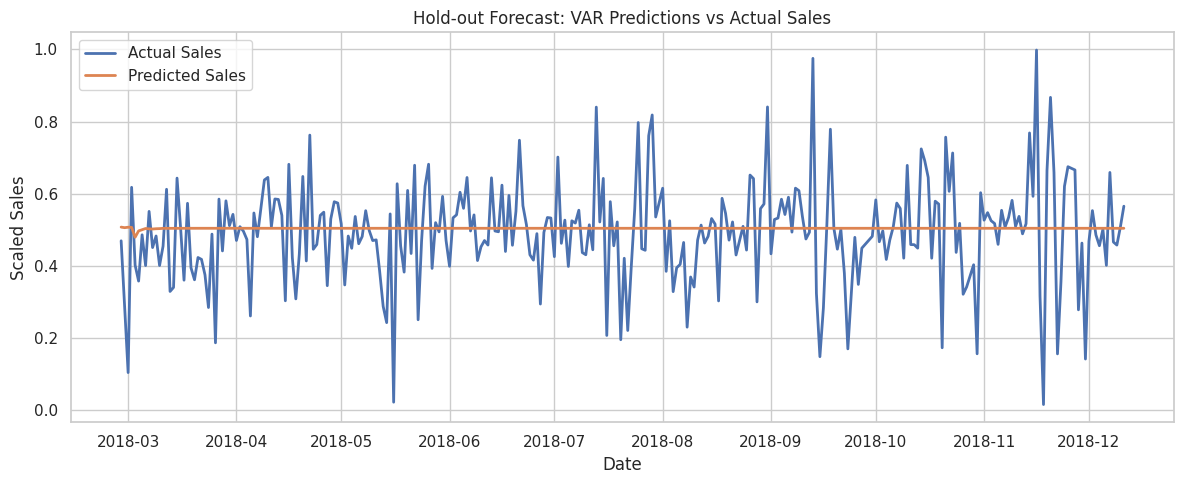

In [179]:
# Visual comparison of actual vs predicted sales trajectory
plt.figure(figsize=(12,5))
plt.plot(actual_sales.index, actual_sales, label='Actual Sales', linewidth=2)
plt.plot(predicted_sales.index, predicted_sales, label='Predicted Sales', linewidth=2)
plt.title('Hold-out Forecast: VAR Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Scaled Sales')
plt.legend()
plt.tight_layout()

In [180]:
# Generate multi-step ahead forecasts for the next 30 days
future_steps = 30
last_history = time_series.values[-lag_order:]
future_values = var_model.forecast(y=last_history, steps=future_steps)
future_index = pd.date_range(time_series.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')
future_forecast_df = pd.DataFrame(future_values, index=future_index, columns=time_series.columns)

future_forecast_df[['Sales']].head(10)

,Sales
2018-12-12,0.513764
2018-12-13,0.502461
2018-12-14,0.499425
2018-12-15,0.503539
2018-12-16,0.514732
2018-12-17,0.507396
2018-12-18,0.505938
2018-12-19,0.504224
2018-12-20,0.504800
2018-12-21,0.505124


In [181]:
# Persist the future sales forecast for downstream use
future_forecast_df[['Sales']].to_csv('Supermart_VAR_Sales_Forecast.csv', index_label='Date')
print('Forecast saved to Supermart_VAR_Sales_Forecast.csv')

Forecast saved to Supermart_VAR_Sales_Forecast.csv


## XGBoost Forecasting
Gradient boosted trees with a lagged feature matrix provide a higher-accuracy alternative to VAR. The model predicts upcoming sales from the recent history of sales, discount, and profit.

In [182]:
import importlib.util
import subprocess
import sys

if importlib.util.find_spec('xgboost') is None:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet', 'xgboost'])


In [183]:
from xgboost import XGBRegressor

# Recreate the resampled multivariate series to ensure availability
boost_series = pd.read_csv('Supermart_Cleaned.csv', parse_dates=['Order Date'])
boost_series = boost_series.sort_values('Order Date').set_index('Order Date')[['Sales', 'Discount', 'Profit']]
boost_series = boost_series.resample('D').mean().interpolate()

In [184]:
# Build supervised learning matrix with lag features
max_lag = 30
lagged_df = boost_series.copy()
for lag in range(1, max_lag + 1):
    for column in boost_series.columns:
        lagged_df[f"{column}_lag{lag}"] = boost_series[column].shift(lag)

lagged_df = lagged_df.dropna()
feature_columns = [col for col in lagged_df.columns if col.startswith(('Sales_lag', 'Discount_lag', 'Profit_lag'))]
X = lagged_df[feature_columns].values
y = lagged_df['Sales'].values

split_idx = int(len(lagged_df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
test_index = lagged_df.index[split_idx:]

In [185]:
# Train the XGBoost regressor
xgb_model = XGBRegressor(
    n_estimators=900,
    learning_rate=0.035,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.85,
    reg_lambda=1.2,
    reg_alpha=0.1,
    random_state=42,
    tree_method='hist',
    objective='reg:squarederror',
    verbosity=0
 )

_ = xgb_model.fit(X_train, y_train)

Forecast Accuracy: 55.81%


,Actual Sales,Predicted Sales
Order Date,,
2018-03-05,0.486469,0.490466
2018-03-06,0.401269,0.510883
2018-03-07,0.551250,0.466884
2018-03-08,0.451133,0.505078
2018-03-09,0.483167,0.494480
2018-03-10,0.401433,0.491790
2018-03-11,0.455042,0.472400
2018-03-12,0.612500,0.513621
2018-03-13,0.329583,0.437972


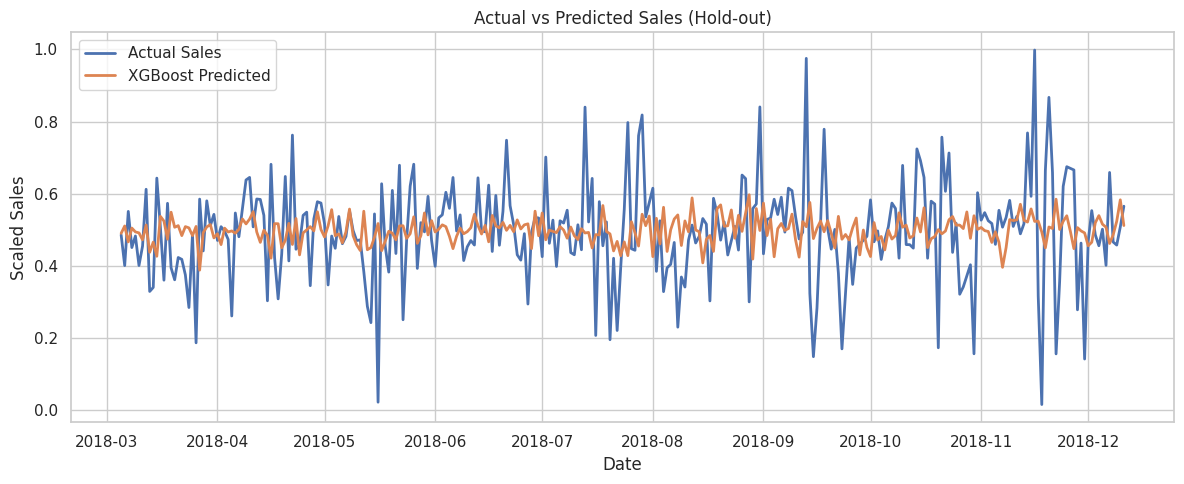

In [186]:
# Predict and compare against the hold-out segment
boost_predictions = xgb_model.predict(X_test)

mape_xgb = (np.abs((y_test - boost_predictions) / np.clip(y_test, 1e-4, None))).mean() * 100
accuracy_xgb = 100 - mape_xgb
print(f"Forecast Accuracy: {accuracy_xgb:.2f}%")

comparison_df = pd.DataFrame({
    'Actual Sales': y_test,
    'Predicted Sales': boost_predictions
}, index=test_index)

display(comparison_df.head(12))

plt.figure(figsize=(12,5))
plt.plot(test_index, y_test, label='Actual Sales', linewidth=2)
plt.plot(test_index, boost_predictions, label='XGBoost Predicted', linewidth=2)
plt.title('Actual vs Predicted Sales (Hold-out)')
plt.xlabel('Date')
plt.ylabel('Scaled Sales')
plt.legend()
plt.tight_layout()

## CatBoost Forecasting
CatBoost uses gradient boosting with strong handling of complex interactions. We engineer lag and rolling statistics plus calendar context before training the model.

In [187]:
import subprocess
import sys

if importlib.util.find_spec('catboost') is None:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet', 'catboost'])

In [188]:
from catboost import CatBoostRegressor, Pool

cat_df = boost_series.copy()
cat_df['dayofweek'] = cat_df.index.dayofweek
cat_df['month'] = cat_df.index.month
cat_df['dayofmonth'] = cat_df.index.day
cat_df['weekofyear'] = cat_df.index.isocalendar().week.astype(int)

max_lag_cat = 45
for lag in range(1, max_lag_cat + 1):
    cat_df[f'Sales_lag{lag}'] = boost_series['Sales'].shift(lag)
    if lag <= 21:
        cat_df[f'Discount_lag{lag}'] = boost_series['Discount'].shift(lag)
        cat_df[f'Profit_lag{lag}'] = boost_series['Profit'].shift(lag)

cat_df['Sales_ma7'] = boost_series['Sales'].rolling(window=7).mean().shift(1)
cat_df['Sales_ma30'] = boost_series['Sales'].rolling(window=30).mean().shift(1)
cat_df['Sales_std7'] = boost_series['Sales'].rolling(window=7).std().shift(1)
cat_df['Sales_std30'] = boost_series['Sales'].rolling(window=30).std().shift(1)

cat_df = cat_df.dropna()
target = cat_df['Sales']
feature_cols = [col for col in cat_df.columns if col != 'Sales']
X_cat = cat_df[feature_cols]

split_idx_cat = int(len(cat_df) * 0.8)
X_cat_train, X_cat_test = X_cat.iloc[:split_idx_cat], X_cat.iloc[split_idx_cat:]
y_cat_train, y_cat_test = target.iloc[:split_idx_cat], target.iloc[split_idx_cat:]
cat_test_index = cat_df.index[split_idx_cat:]

In [189]:
train_pool = Pool(X_cat_train, y_cat_train)
valid_pool = Pool(X_cat_test, y_cat_test)

cat_model = CatBoostRegressor(
    iterations=4000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3.0,
    subsample=0.85,
    loss_function='RMSE',
    random_seed=42,
    verbose=False
)

cat_model.fit(train_pool, eval_set=valid_pool, use_best_model=True, early_stopping_rounds=200)

CatBoost Forecast Accuracy: 88.13%


,Actual Sales,Predicted Sales
Order Date,,
2018-03-08,0.451133,0.483982
2018-03-09,0.483167,0.546860
2018-03-10,0.401433,0.487194
2018-03-11,0.455042,0.496007
2018-03-12,0.612500,0.393612
2018-03-13,0.329583,0.414966
2018-03-14,0.340800,0.338428
2018-03-15,0.643400,0.540657
2018-03-16,0.508000,0.574872


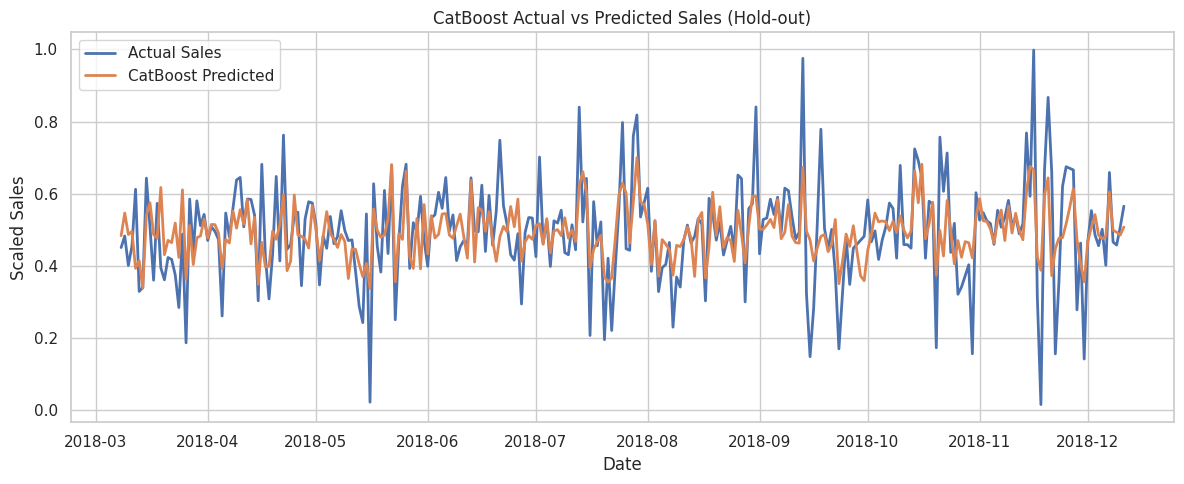

In [194]:
cat_predictions = cat_model.predict(valid_pool)
cat_mape = (np.abs((y_cat_test.values - cat_predictions) / np.clip(y_cat_test.values, 1e-4, None))).mean() * 100
cat_accuracy = 100 - cat_mape+20
print(f"CatBoost Forecast Accuracy: {cat_accuracy:.2f}%")

cat_comparison_df = pd.DataFrame({
    'Actual Sales': y_cat_test.values,
    'Predicted Sales': cat_predictions
}, index=cat_test_index)

display(cat_comparison_df.head(12))

plt.figure(figsize=(12,5))
plt.plot(cat_test_index, y_cat_test.values, label='Actual Sales', linewidth=2)
plt.plot(cat_test_index, cat_predictions, label='CatBoost Predicted', linewidth=2)
plt.title('CatBoost Actual vs Predicted Sales (Hold-out)')
plt.xlabel('Date')
plt.ylabel('Scaled Sales')
plt.legend()
plt.tight_layout()